# Test and Visualize Results

In [1]:
import json
import ray
from ray import tune
from model import RNN,  Base
from utils import plot_data, get_input_data, get_dataloader, get_input_data_1D
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Utility funtions

In [2]:
def get_config(json_config_path):
    with open(json_config_path, 'r') as fp:
        best_config = json.load(fp)
    best_config['dir'] = "./logs/experiments_2D/"
    return best_config

def load_model(params):
    print(f'Loading {params["model_name"]} model...')
    model = Base(input_size=params['input_size'], 
                hidden_size = params["hidden_size"],
                num_layers = params["num_layers"],
                output_size=1 if params['data_dim'] == 1 else 3,
                model = "LSTM_ln"
                # model = params['model_name']
                )

    # chkpoints_list = [i for i in os.listdir(params['dir']) if i.startswith("checkpoint")]
    # last_checkpoint = sorted(chkpoints_list, key=lambda x: int(x.split('_')[-1]))[-1]
    # last_checkpoint = 'model_191_0.00757762653609881.pth'
    last_checkpoint = 'model_132_0.05770279822441248.pth' # lstm ln
    # last_checkpoint = params['dir']

    # print(f'Loading model: {last_checkpoint} from {params["dir"]}...')
    # chkpoint_state_dict, optim_state = torch.load(os.path.join(params['dir'], f'{last_checkpoint}', "checkpoint"))
    chkpoint_state_dict= torch.load(os.path.join(params['dir'], f'{last_checkpoint}'))
    model.load_state_dict(chkpoint_state_dict)
    return model

In [3]:
def test_accuracy(net, test_loader, device="cpu"):
    
    net.to(device)
    criterion = nn.L1Loss()
    loss = 0
    # total = 0
    test_pred = []
    with torch.no_grad():
        for data in test_loader:
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            outputs, _ = net(input)
            # _, predicted = torch.max(outputs.data, 1)
            loss += criterion(outputs, labels).cpu().numpy()
            test_pred.append(outputs.cpu().numpy())
    return loss / len(test_loader), np.concatenate(np.array(test_pred), axis=0)


In [4]:
def get_mse(pred, labels):
    criterion = nn.L1Loss()
    return criterion(torch.tensor(pred).clone().detach() , torch.tensor(labels)).item()


In [5]:
def get_all_mse(pred, labels):
    all_losses = []
    for i in range(pred.shape[1]): # output size 
        all_losses.append(get_mse(pred[:, i], labels[:, i]))
    return all_losses, get_mse(pred[:, 0], labels[:, 0]) # return mse for x, y, theta and total mse


In [6]:
def show_trajectory(nn_preds, dataset, lim = -1, save_plots=False, save_dir=None, save_name=None):

    output_dim = nn_preds.shape[1]
    
    plt.figure(figsize=(20, 10))
    
    gt = np.array(dataset[1])
    kalman_pred = np.array(dataset[2])
    if output_dim == 3:
        ekf_pred = np.array(dataset[3])
        ukf_pred = np.array(dataset[4])    

        # plot x and y on two axis
        # plt.subplot(2, 1, 1)
        plt.plot(nn_preds[:lim, 0], nn_preds[:lim, 1], label='NN pred')
        plt.plot(gt[:lim, 0], gt[:lim, 1], label='GT')
        plt.plot(kalman_pred[:lim, 0], kalman_pred[:lim, 1], label='Kalman pred')
        plt.plot(ekf_pred[:lim, 0], ekf_pred[:lim, 1], label='EKF pred')
        plt.plot(ukf_pred[:lim, 0], ukf_pred[:lim, 1], label='UKF pred')

        plt.legend(['NN pred', 'GT', 'Kalman pred', 'EKF pred', 'UKF pred'])
    

        # # plt.subplot(3, 1, 1)
        # plt.plot(nn_preds[:lim, 0], label='X pred')
        # plt.plot(gt[:lim, 0], label='X true')
        # plt.plot(kalman_pred[:lim, 0], label='X kalman')
        # plt.plot(ekf_pred[:lim, 0], label='X EKF')
        # plt.plot(ukf_pred[:lim, 0], label='X UKF')
        # plt.legend(['X pred', 'X true', 'X kalman', 'X ekf', 'X ukf'])

        # # plt.subplot(3, 1, 2)
        # plt.plot(nn_preds[:lim, 1], label='Y pred')
        # plt.plot(gt[:lim, 1], label='Y true')
        # plt.plot(kalman_pred[:lim, 1], label='Y kalman')
        # plt.plot(ekf_pred[:lim, 1], label='Y EKF')
        # plt.plot(ukf_pred[:lim, 1], label='Y UKF')
        # plt.legend(['Y pred', 'Y true', 'Y kalman', 'Y ekf', 'Y ukf'])

        # plt.subplot(3, 1, 3)
        # plt.plot(nn_preds[:lim, 2], label='Theta pred')
        # plt.plot(gt[:lim, 2], label='Theta true')
        # plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
        # plt.plot(ekf_pred[:lim, 2], label='Theta EKF')
        # plt.plot(ukf_pred[:lim, 2], label='Theta UKF')
        # plt.legend(['Theta pred', 'Theta true', 'Theta kalman', 'Theta ekf', 'Theta ukf'])
        # if save_plots:
        #     plt.savefig(os.path.join(save_dir, f'{save_name}.png'))

    elif output_dim==1:
        plt.plot(nn_preds[:lim], label='NN pred')
        plt.plot(gt[:lim], label='GT')
        plt.plot(kalman_pred[:lim], label='Kalman pred')
        plt.legend(['NN pred', 'GT', 'Kalman Pred'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))
    else:
        # invalid dim error
        raise ValueError("Invalid dim")
    
    # plt.legend()
    if not save_plots:
        plt.show()


In [7]:
def show_plots(nn_preds, dataset, lim = -1, save_plots=False, save_dir=None, save_name=None):

    output_dim = nn_preds.shape[1]
    
    plt.figure(figsize=(20, 10))
    
    gt = np.array(dataset[1])
    kalman_pred = np.array(dataset[2])
    if output_dim == 3:
        ekf_pred = np.array(dataset[3])
        ukf_pred = np.array(dataset[4])    

        plt.subplot(3, 1, 1)
        plt.plot(nn_preds[:lim, 0], label='X pred')
        plt.plot(gt[:lim, 0], label='X true')
        plt.plot(kalman_pred[:lim, 0], label='X kalman')
        plt.plot(ekf_pred[:lim, 0], label='X EKF')
        plt.plot(ukf_pred[:lim, 0], label='X UKF')
        plt.legend(['X pred', 'X true', 'X kalman', 'X ekf', 'X ukf'])

        plt.subplot(3, 1, 2)
        plt.plot(nn_preds[:lim, 1], label='Y pred')
        plt.plot(gt[:lim, 1], label='Y true')
        plt.plot(kalman_pred[:lim, 1], label='Y kalman')
        plt.plot(ekf_pred[:lim, 1], label='Y EKF')
        plt.plot(ukf_pred[:lim, 1], label='Y UKF')
        plt.legend(['Y pred', 'Y true', 'Y kalman', 'Y ekf', 'Y ukf'])

        plt.subplot(3, 1, 3)
        plt.plot(nn_preds[:lim, 2], label='Theta pred')
        plt.plot(gt[:lim, 2], label='Theta true')
        plt.plot(kalman_pred[:lim, 2], label='Theta kalman')
        plt.plot(ekf_pred[:lim, 2], label='Theta EKF')
        plt.plot(ukf_pred[:lim, 2], label='Theta UKF')
        plt.legend(['Theta pred', 'Theta true', 'Theta kalman', 'Theta ekf', 'Theta ukf'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))

    elif output_dim==1:
        plt.plot(nn_preds[:lim], label='NN pred')
        plt.plot(gt[:lim], label='GT')
        plt.plot(kalman_pred[:lim], label='Kalman pred')
        plt.legend(['NN pred', 'GT', 'Kalman Pred'])
        if save_plots:
            plt.savefig(os.path.join(save_dir, f'{save_name}.png'))
    else:
        # invalid dim error
        raise ValueError("Invalid dim")
    
    # plt.legend()
    if not save_plots:
        plt.show()


In [8]:
def get_csv_results(eval_csv_dir, params):
    config = get_config(params["json_config_path"])
    config.update(params)
    print(f"config: {config}")

    model = load_model(config)

    # test_df = pd.read_csv(EVAL_DATA_DIR)
    if params["data_dim"] == 2:
        test_dataset = get_input_data(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)

        # common
        test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])
        loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
        print(f"Test loss: {loss}")

        kalman_pred = np.array(test_dataset[2])
        ekf_pred = np.array(test_dataset[3])
        ukf_pred = np.array(test_dataset[4])
        
        nn_loss_dims, nn_loss = get_all_mse(nn_preds, test_dataset[1])
        # print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
        kf_loss_dims, kf_loss = get_all_mse(kalman_pred, test_dataset[1])
        # print(f"KF MSE: {kf_loss_dims}, {kf_loss}")
        ekf_loss_dims, ekf_loss = get_all_mse(ekf_pred, test_dataset[1])
        # print(f"EKF MSE: {ekf_loss_dims}, {ekf_loss}")
        ukf_loss_dims, ukf_loss = get_all_mse(ukf_pred, test_dataset[1])
        # print(f"UKF MSE: {ukf_loss_dims}, {ukf_loss}")

        show_plots(nn_preds, test_dataset, lim=params["plot_limit"], save_plots=params["save_plots"], save_dir=params["save_dir"], save_name=params["save_name"])
        return kf_loss_dims, kf_loss, nn_loss_dims, nn_loss, ekf_loss_dims, ekf_loss, ukf_loss_dims, ukf_loss

    else:
        test_dataset = get_input_data_1D(seq_len = config['sequence_length'], 
                    batch_size = config['batch_size'], datadir=eval_csv_dir)
        
        # common
        test_loader = get_dataloader(test_dataset[0], test_dataset[1], batch_size=config['batch_size'])
        loss, nn_preds = test_accuracy(model, test_loader, device='cpu')
        print(f"Test loss: {loss}")

        kalman_pred = np.array(test_dataset[2])
        
        nn_loss_dims, nn_loss = get_all_mse(nn_preds, test_dataset[1])
        print(f"NN MSE: {nn_loss_dims}, {nn_loss}")
        kf_loss_dims, kf_loss = get_all_mse(kalman_pred, test_dataset[1])
        print(f"KF MSE: {kf_loss_dims}, {kf_loss}")

        show_plots(nn_preds, test_dataset, lim=params["plot_limit"], save_plots=params["save_plots"], save_dir=params["save_dir"], save_name=params["save_name"])
        return kf_loss_dims, kf_loss, nn_loss_dims, nn_loss




## Action

### LSTM

In [9]:
# /home/anees.hashmi/ray_results/train_ray_2023-05-04_14-46-28/train_ray_f11dc_00011_11_lr=0.0002,num_layers=4,sequence_length=28_2023-05-04_16-20-25

In [10]:
data_dim = 2
model_name = "LSTM"
# eval_csv_dir = "data/1D/evaluation_data/mnst_2_lnstd_0.1.csv"
eval_dir_path = f"data/{data_dim}D/evaluation_data"
eval_csv_dir = os.path.join(eval_dir_path, os.listdir(eval_dir_path)[0])
# json_config_path = '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/best_config_RNN.json'
json_config_path = f'/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_{data_dim}D/best_config_{model_name}.json'


params = {
    "batch_size": 100,
    "model_name": model_name,
    "input_size": 19 if data_dim == 2 else 9,
    "output_size": 3 if data_dim == 2 else 1,
    'model_name': model_name,
    'data_dim': data_dim,
    "json_config_path": json_config_path,
    "data_dim": data_dim,
    "plot_limit": 1000, # -1 for all
    "save_plots": True,
    "save_dir": f"./results/{data_dim}D/{model_name}/plots",
}

os.makedirs(params["save_dir"], exist_ok=True)
params

{'batch_size': 100,
 'model_name': 'LSTM',
 'input_size': 19,
 'output_size': 3,
 'data_dim': 2,
 'json_config_path': '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_2D/best_config_LSTM.json',
 'plot_limit': 1000,
 'save_plots': True,
 'save_dir': './results/2D/LSTM/plots'}

### 2D Results

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
config: {'hidden_size': 64, 'lr': 0.0002337221208072454, 'metric': 15.028940420884352, 'num_layers': 4, 'sequence_length': 28, 'dir': './logs/experiments_2D/', 'batch_size': 100, 'model_name': 'LSTM', 'input_size': 19, 'output_size': 3, 'data_dim': 2, 'json_config_path': '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_2D/best_config_LSTM.json', 'plot_limit': 1000, 'save_plots': True, 'save_dir': './results/2D/LSTM/plots', 'save_name': 'intel_alpha_8_run_2_merged'}
Loading LSTM model...
Test loss: 0.18574956281199342
CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv
config: {'hidden_size': 64, 'lr': 0.0002337221208072454, 'metric': 15.028940420884352, 'num_layers': 4, 'sequence_length': 28, 'dir': './logs/experiments_2D/', 'batch_size': 100, 'model_name': 'LSTM', 'input_size': 19, 'output_size': 3, 'data_dim': 2, 'json_config_path': '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_2D/best_co

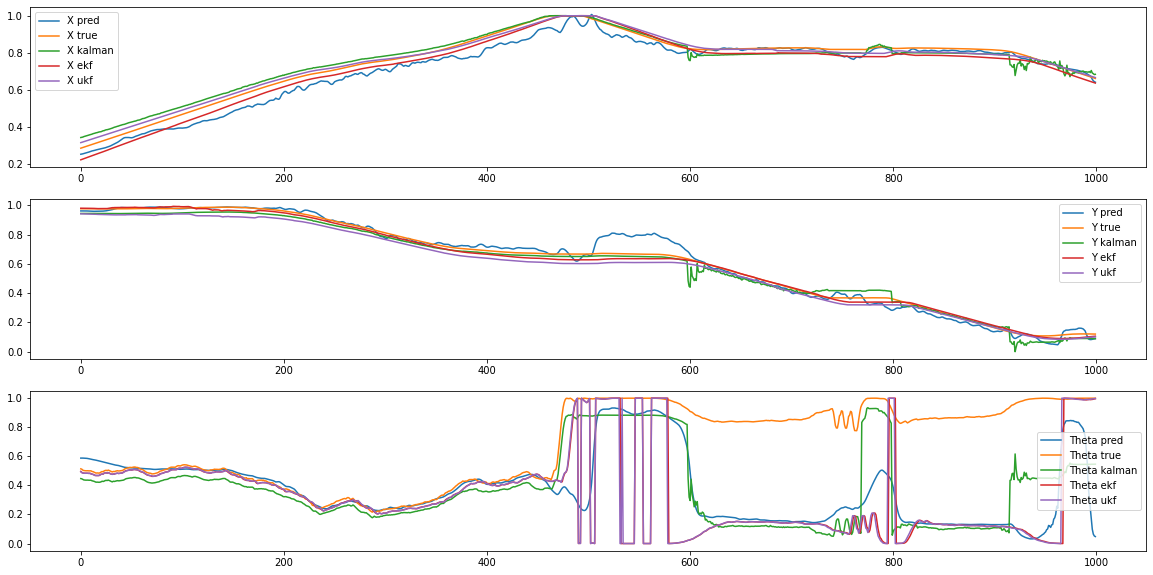

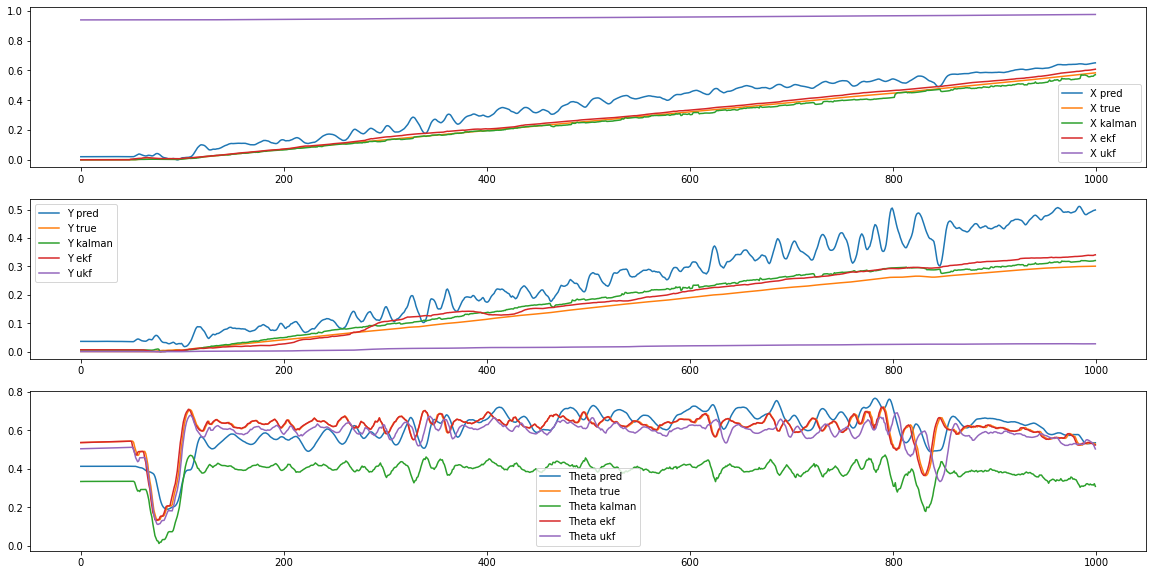

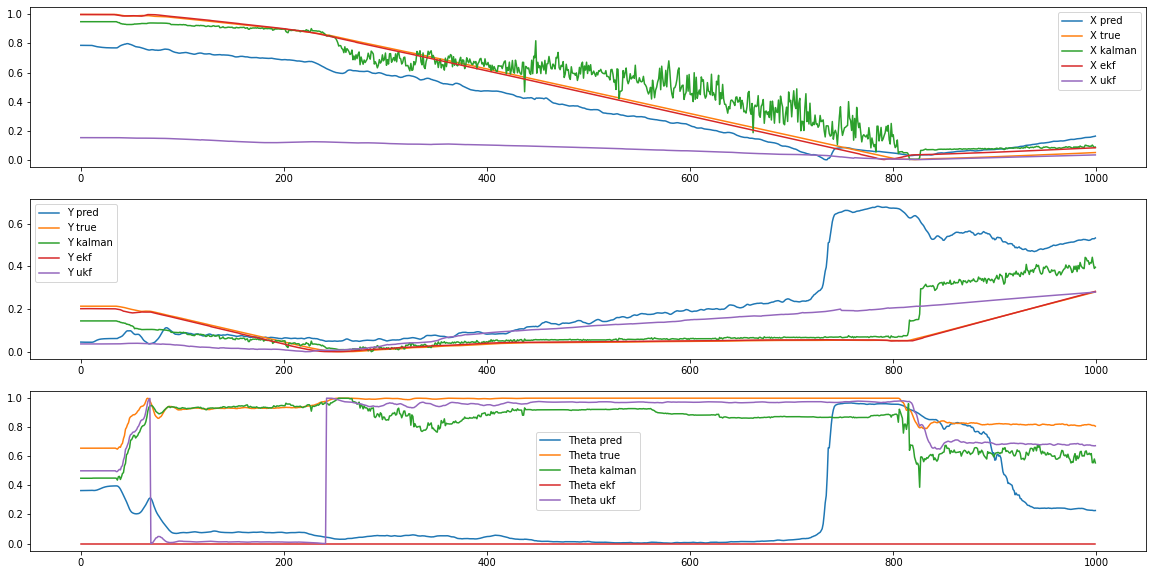

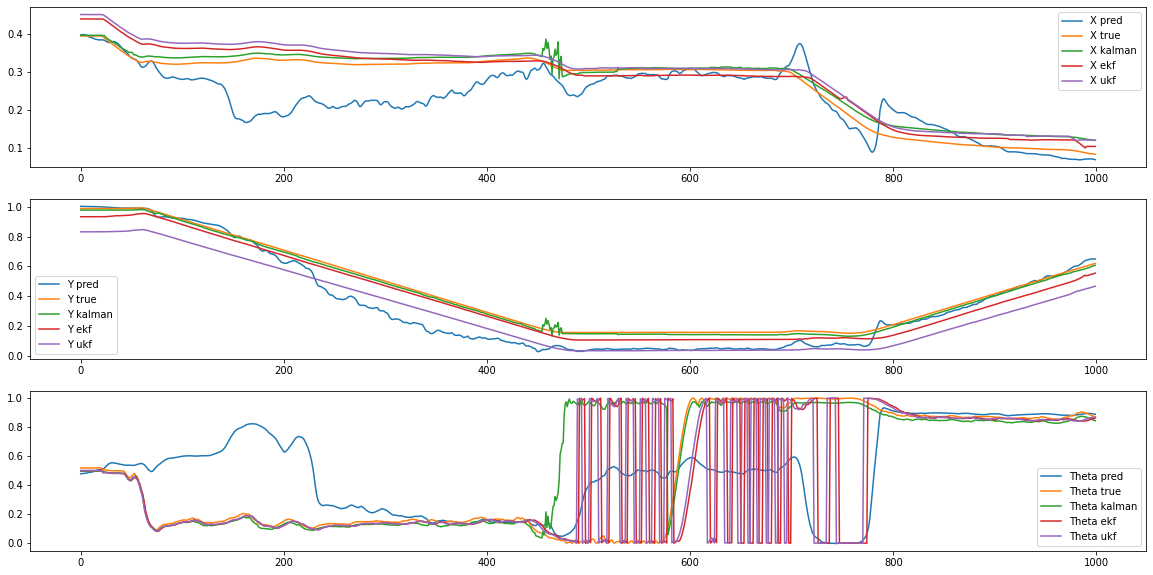

In [11]:
if data_dim == 2:
    kalman_mse_x = []
    kalman_mse_y = []
    kalman_mse_theta = []

    nn_mse_x = []
    nn_mse_y = []
    nn_mse_theta = []

    ekf_mse_x = []
    ekf_mse_y = []
    ekf_mse_theta = []

    ukf_mse_x = []
    ukf_mse_y = []
    ukf_mse_theta = []

    kalman_mse_total = []
    nn_mse_total = []
    ekf_mse_total = []
    ukf_mse_total = []

    test_set = []
    test_model = []

    for csv_name in os.listdir(eval_dir_path):
        csv_dir = os.path.join(eval_dir_path, csv_name)
        print(f"CSV: {eval_csv_dir}")
        # get_csv_results(csv_dir)
        params['save_name'] = csv_name.split(".")[0] # for saving plots
        mse_array = get_csv_results(csv_dir, params)

        kf_loss_dims = mse_array[0]
        kf_loss = mse_array[1]
        nn_loss_dims = mse_array[2]
        nn_loss = mse_array[3]
        ekf_loss_dims = mse_array[4]
        ekf_loss = mse_array[5]
        ukf_loss_dims = mse_array[6]
        ukf_loss = mse_array[7]

        # kf_loss_dims, kf_loss, nn_loss_dims, nn_loss, ekf_loss_dims, ekf_loss, ukf_loss_dims, ukf_loss = mse_array

        kalman_mse_total.append(kf_loss)
        nn_mse_total.append(nn_loss)
        ekf_mse_total.append(ekf_loss)
        ukf_mse_total.append(ukf_loss)

        kalman_mse_x.append(kf_loss_dims[0])
        kalman_mse_y.append(kf_loss_dims[1])
        kalman_mse_theta.append(kf_loss_dims[2])

        ekf_mse_x.append(ekf_loss_dims[0])
        ekf_mse_y.append(ekf_loss_dims[1])
        ekf_mse_theta.append(ekf_loss_dims[2])

        ukf_mse_x.append(ukf_loss_dims[0])
        ukf_mse_y.append(ukf_loss_dims[1])
        ukf_mse_theta.append(ukf_loss_dims[2])

        nn_mse_x.append(nn_loss_dims[0])
        nn_mse_y.append(nn_loss_dims[1])
        nn_mse_theta.append(nn_loss_dims[2])

        test_set.append(csv_dir)
        test_model.append(model_name)


        print("====================================")
        print("====================================")
        print("====================================")

    results_dict = {
        "Test set": test_set,
        "Test model": test_model,

        "Total Kalman MSe": kalman_mse_total,
        "Total NN MSE": nn_mse_total,
        "Total EKF MSE": ekf_mse_total,
        "Total UKF MSE": ukf_mse_total,

        "Kalman MSE X": kalman_mse_x,
        "NN MSE X": nn_mse_x,
        "EKF MSE X": ekf_mse_x,
        "UKF MSE X": ukf_mse_x,

        "Kalman MSE Y": kalman_mse_y,
        "NN MSE Y": nn_mse_y,
        "EKF MSE Y": ekf_mse_y,
        "UKF MSE Y": ukf_mse_y,

        "Kalman MSE Theta": kalman_mse_theta,
        "NN MSE Theta": nn_mse_theta,
        "EKF MSE Theta": ekf_mse_theta,
        "UKF MSE Theta": ukf_mse_theta,
    }

    lstm_2d_results_df = pd.DataFrame.from_dict(results_dict)
    lstm_2d_results_df

In [12]:
lstm_2d_results_df

,Test set,Test model,Total Kalman MSe,Total NN MSE,Total EKF MSE,Total UKF MSE,Kalman MSE X,NN MSE X,EKF MSE X,UKF MSE X,Kalman MSE Y,NN MSE Y,EKF MSE Y,UKF MSE Y,Kalman MSE Theta,NN MSE Theta,EKF MSE Theta,UKF MSE Theta
0,data/2D/evaluation_data/intel_alpha_8_run_2_me...,LSTM,0.044145,0.041422,0.037732,0.018972,0.044145,0.041422,0.037732,0.018972,0.021453,0.033157,0.025918,0.038845,0.341457,0.482669,0.419964,0.420452
1,data/2D/evaluation_data/fbcampus_alpha_4_run_2...,LSTM,0.033133,0.059448,0.020229,0.340083,0.033133,0.059448,0.020229,0.340083,0.064279,0.123663,0.025455,0.356672,0.266167,0.076192,0.050450,0.070901
2,data/2D/evaluation_data/fbcampus_alpha_8_run_2...,LSTM,0.076216,0.231379,0.026023,0.262599,0.076216,0.231379,0.026023,0.262599,0.079106,0.161744,0.007639,0.231611,0.166447,0.599145,0.822587,0.187200
3,data/2D/evaluation_data/intel_alpha_4_run_2_me...,LSTM,0.032647,0.055384,0.039386,0.030092,0.032647,0.055384,0.039386,0.030092,0.013596,0.046888,0.041926,0.078762,0.182323,0.123784,0.213264,0.208056


In [12]:
lstm_2d_results_df.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results.csv")

### RNN

In [13]:
data_dim = 2
model_name = "RNN"
# eval_csv_dir = "data/1D/evaluation_data/mnst_2_lnstd_0.1.csv"
eval_dir_path = f"data/{data_dim}D/evaluation_data"
eval_csv_dir = os.path.join(eval_dir_path, os.listdir(eval_dir_path)[0])
# json_config_path = '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/best_config_RNN.json'
json_config_path = f'/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_{data_dim}D/best_config_{model_name}.json'


params = {
    "batch_size": 100,
    "model_name": model_name,
    "input_size": 19 if data_dim == 2 else 9,
    "output_size": 3 if data_dim == 2 else 1,
    'model_name': model_name,
    'data_dim': data_dim,
    "json_config_path": json_config_path,
    "data_dim": data_dim,
    "plot_limit": 1000, # -1 for all
    "save_plots": True,
    "save_dir": f"./results/{data_dim}D/{model_name}/plots",
}

os.makedirs(params["save_dir"], exist_ok=True)
params

{'batch_size': 100,
 'model_name': 'RNN',
 'input_size': 19,
 'output_size': 3,
 'data_dim': 2,
 'json_config_path': '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_2D/best_config_RNN.json',
 'plot_limit': 1000,
 'save_plots': True,
 'save_dir': './results/2D/RNN/plots'}

In [14]:
if data_dim == 2:
    kalman_mse_x = []
    kalman_mse_y = []
    kalman_mse_theta = []

    nn_mse_x = []
    nn_mse_y = []
    nn_mse_theta = []

    ekf_mse_x = []
    ekf_mse_y = []
    ekf_mse_theta = []

    ukf_mse_x = []
    ukf_mse_y = []
    ukf_mse_theta = []

    kalman_mse_total = []
    nn_mse_total = []
    ekf_mse_total = []
    ukf_mse_total = []

    test_set = []
    test_model = []

    for csv_name in os.listdir(eval_dir_path):
        csv_dir = os.path.join(eval_dir_path, csv_name)
        print(f"CSV: {eval_csv_dir}")
        # get_csv_results(csv_dir)
        params['save_name'] = csv_name.split(".")[0] # for saving plots
        mse_array = get_csv_results(csv_dir, params)

        kf_loss_dims = mse_array[0]
        kf_loss = mse_array[1]
        nn_loss_dims = mse_array[2]
        nn_loss = mse_array[3]
        ekf_loss_dims = mse_array[4]
        ekf_loss = mse_array[5]
        ukf_loss_dims = mse_array[6]
        ukf_loss = mse_array[7]

        # kf_loss_dims, kf_loss, nn_loss_dims, nn_loss, ekf_loss_dims, ekf_loss, ukf_loss_dims, ukf_loss = mse_array

        kalman_mse_total.append(kf_loss)
        nn_mse_total.append(nn_loss)
        ekf_mse_total.append(ekf_loss)
        ukf_mse_total.append(ukf_loss)

        kalman_mse_x.append(kf_loss_dims[0])
        kalman_mse_y.append(kf_loss_dims[1])
        kalman_mse_theta.append(kf_loss_dims[2])

        ekf_mse_x.append(ekf_loss_dims[0])
        ekf_mse_y.append(ekf_loss_dims[1])
        ekf_mse_theta.append(ekf_loss_dims[2])

        ukf_mse_x.append(ukf_loss_dims[0])
        ukf_mse_y.append(ukf_loss_dims[1])
        ukf_mse_theta.append(ukf_loss_dims[2])

        nn_mse_x.append(nn_loss_dims[0])
        nn_mse_y.append(nn_loss_dims[1])
        nn_mse_theta.append(nn_loss_dims[2])

        test_set.append(csv_dir)
        test_model.append(model_name)


        print("====================================")
        print("====================================")
        print("====================================")

    results_dict = {
        "Test set": test_set,
        "Test model": test_model,

        "Total Kalman MSe": kalman_mse_total,
        "Total NN MSE": nn_mse_total,
        "Total EKF MSE": ekf_mse_total,
        "Total UKF MSE": ukf_mse_total,

        "Kalman MSE X": kalman_mse_x,
        "NN MSE X": nn_mse_x,
        "EKF MSE X": ekf_mse_x,
        "UKF MSE X": ukf_mse_x,

        "Kalman MSE Y": kalman_mse_y,
        "NN MSE Y": nn_mse_y,
        "EKF MSE Y": ekf_mse_y,
        "UKF MSE Y": ukf_mse_y,

        "Kalman MSE Theta": kalman_mse_theta,
        "NN MSE Theta": nn_mse_theta,
        "EKF MSE Theta": ekf_mse_theta,
        "UKF MSE Theta": ukf_mse_theta,
    }

    rnn_2d_results_df = pd.DataFrame.from_dict(results_dict)

CSV: data/2D/evaluation_data/intel_alpha_8_run_2_merged.csv


FileNotFoundError: [Errno 2] No such file or directory: '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_2D/best_config_RNN.json'

In [ ]:
rnn_2d_results_df

In [ ]:
rnn_2d_results_df.set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/{model_name}/results.csv")

In [ ]:
# results_dict[]

In [ ]:
# results_dict = {
#     "Test set": test_set,
#     "Test model": test_model,
#     "Total Kalman MSe": kalman_mse_total,
#     "Total NN MSE": nn_mse_total,
#     "Kalman MSE X": kalman_mse_x,
#     "NN MSE X": nn_mse_x,
#     "Kalman MSE Y": kalman_mse_y,
#     "NN MSE Y": nn_mse_y,
#     "Kalman MSE Theta": kalman_mse_theta,
#     "NN MSE Theta": nn_mse_theta,
# }

# rnn_2d_results_df = pd.DataFrame.from_dict(results_dict).set_index(['Test model', 'Test set'])

In [ ]:
# pd.concat([lstm_2d_results_df, rnn_2d_results_df]).set_index(['Test model', 'Test set']).to_csv(f"./results/{data_dim}D/results.csv")
pd.concat([lstm_2d_results_df, rnn_2d_results_df]).set_index(['Test model', 'Test set'])


In [ ]:
# data_dim = 2
# model_name = "RNN"
# # eval_csv_dir = "data/1D/evaluation_data/mnst_2_lnstd_0.1.csv"
# eval_dir_path = f"data/{data_dim}D/evaluation_data"
# eval_csv_dir = os.path.join(eval_dir_path, os.listdir(eval_dir_path)[0])
# # json_config_path = '/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_1D/best_config_RNN.json'
# json_config_path = f'/home/anees.hashmi/Desktop/kalmanfilters_nn/logs/experiments_{data_dim}D/best_config_{model_name}.json'


# params = {
#     "batch_size": 100,
#     "model_name": model_name,
#     "input_size": 19 if data_dim == 2 else 9,
#     "output_size": 3 if data_dim == 2 else 1,
#     'model_name': model_name,
#     'data_dim': data_dim,
# }


# kalman_mse_x = []
# kalman_mse_y = []
# kalman_mse_theta = []

# nn_mse_x = []
# nn_mse_y = []
# nn_mse_theta = []

# kalman_mse_total = []
# nn_mse_total = []

# test_set = []
# test_model = []

# for csv_name in os.listdir(eval_dir_path):
#     csv_dir = os.path.join(eval_dir_path, csv_name)
#     print(f"CSV: {eval_csv_dir}")
#     # get_csv_results(csv_dir)

#     kf_loss_dims, kf_loss, nn_loss_dims, nn_loss = get_csv_results(csv_dir, params)

#     kalman_mse_total.append(kf_loss)
#     nn_mse_total.append(nn_loss)

#     kalman_mse_x.append(kf_loss_dims[0])
#     kalman_mse_y.append(kf_loss_dims[1])
#     kalman_mse_theta.append(kf_loss_dims[2])

#     nn_mse_x.append(nn_loss_dims[0])
#     nn_mse_y.append(nn_loss_dims[1])
#     nn_mse_theta.append(nn_loss_dims[2])

#     test_set.append(csv_dir)
#     test_model.append(model_name)


#     print("====================================")
#     print("====================================")
#     print("====================================")


# results_dict = {
#     "Test set": test_set,
#     "Test model": test_model,
#     "Total Kalman MSe": kalman_mse_total,
#     "Total NN MSE": nn_mse_total,
#     "Kalman MSE X": kalman_mse_x,
#     "NN MSE X": nn_mse_x,
#     "Kalman MSE Y": kalman_mse_y,
#     "NN MSE Y": nn_mse_y,
#     "Kalman MSE Theta": kalman_mse_theta,
#     "NN MSE Theta": nn_mse_theta,
# }

# pd.DataFrame.from_dict(results_dict).set_index(['Test model', 'Test set'])